## Sprite Siamese Network
- Intended to be a "CLIP"-like text2image evaluator to determine which text encodings are closest to images using few-shot learning
- Code taken from the Siamese Network architecture used in the fingerprint clustering and from https://keras.io/examples/vision/siamese_network/

---

#### Imports and Configuration

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input

/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-25 12:18:56.981788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal

In [3]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


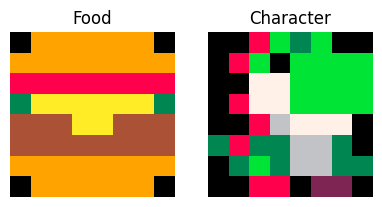

In [4]:
# import the dataset to use (pico-characters)

# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

In [5]:
# get the text descriptions and convert to embeddings

# import sentence-transformer for text embedding 
SBERT_MODEL = SentenceTransformer('bert-base-nli-mean-tokens')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

# import the text data
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# encode the labels
pico_char_labels_emb = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels")
    for l in pico_char_labels:
        pico_char_labels_emb.append(sentEmb(l))
        pbar.update(1)

Encoding labels: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


Character: a red robot dog


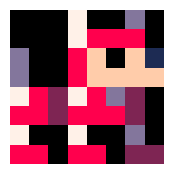

Encoding length: 768


In [6]:
# show a random character and its description
rand_char_idx = random.randint(0,len(pico_char_labels))
print(f"Character: {pico_char_labels[rand_char_idx]}")
showSprPalette(pico_char_dat[rand_char_idx])

desc_enc = pico_char_labels_emb[rand_char_idx]
print(f"Encoding length: {len(desc_enc)}")

#### Siamese Network Setup

In [12]:
# pairs up images to text 
def pairing(imgs, text):
    pairX = []    # texts - image
    pairY = []    # 1 for positive, 0 for negative

    for i in range(len(imgs)):
        # pair text to the correct image (positive pair)
        pairX.append([text[i],imgs[i]])
        pairY.append(1)

        # pair text to a random image (negative pair)
        all_but_i = list(range(len(imgs)))
        rand_img = random.choice(all_but_i[:i] + all_but_i[i+1:])
        pairX.append([text[i],imgs[rand_img]])
        pairY.append(0)

    return np.array(pairX), np.array(pairY)


X_dat, y_dat = pairing(pico_char_dat, pico_char_labels_emb)

/var/folders/5h/0zjb1m296y1gvhtd9q40w4yc0000gn/T/ipykernel_9235/1505579227.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pairX), np.array(pairY)
